In [1]:
# %% [markdown]
# # 02 - Entraînement SVM sur MFCC agrégés
#
# Dans ce notebook, on :
# 1. Charge le dataset SVM (features MFCC + delta moyens par fenêtre)
# 2. Sépare en train / test
# 3. Normalise les features
# 4. Entraîne un SVM (kernel RBF)
# 5. Évalue le modèle (accuracy, classification report, matrice de confusion)
# 6. Sauvegarde le modèle et le scaler

# %%
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix
)
import joblib

# Chemin vers le fichier CSV contenant les features SVM
SVM_CSV_PATH = r"C:/Users/PC/Documents/a_PROJET_5A/Projet_5A/training/datasets/X_svm.csv"

# Dossier de sauvegarde du modèle
MODEL_DIR = r"C:/Users/PC/Documents/a_PROJET_5A/Projet_5A/training/models"
os.makedirs(MODEL_DIR, exist_ok=True)

print("Chemin dataset SVM :", SVM_CSV_PATH)
print("Dossier modèles    :", MODEL_DIR)

Chemin dataset SVM : C:/Users/PC/Documents/a_PROJET_5A/Projet_5A/training/datasets/X_svm.csv
Dossier modèles    : C:/Users/PC/Documents/a_PROJET_5A/Projet_5A/training/models


In [2]:
# %%
# Chargement du dataset SVM
# On suppose que le CSV contient :
# - une colonne 'label' (entier 0..4)
# - toutes les autres colonnes = features numériques (MFCC + delta moyens)

df = pd.read_csv(SVM_CSV_PATH)

print("Aperçu du dataset SVM :")
display(df.head())
print("Shape du dataset :", df.shape)

# Vérification de la présence de la colonne 'label'
assert "label" in df.columns, "La colonne 'label' doit exister dans X_svm.csv"

# %%
# Séparation features / labels
X = df.drop(columns=["label"]).values  # matrice (N_samples, N_features)
y = df["label"].values                 # vecteur (N_samples,)

print("Shape X :", X.shape)
print("Shape y :", y.shape)
print("Labels uniques :", np.unique(y))

Aperçu du dataset SVM :


,0,1,2,3,4,5,6,7,8,9,...,231,232,233,234,235,236,237,238,239,label
0,191.978041,47.557557,5.928516,2.505167,3.797235,8.935038,1.559144,-6.549589,-0.624321,-8.889390,...,0.835766,-1.631437,0.982423,1.028617,1.215663,0.363303,-0.345149,-0.259382,-0.242388,0
1,164.445440,56.499087,-0.525131,-4.038000,4.493569,3.734896,-2.178953,-6.505348,-5.754505,-10.609743,...,1.236625,-0.148266,0.175626,-0.718326,-0.708145,-0.355384,-0.971751,-0.514216,-1.167818,0
2,131.193363,63.738376,0.499168,1.985677,0.129958,8.420248,-1.558510,-7.323018,-5.446665,-5.197325,...,0.003162,0.439908,0.739079,-0.430548,-0.199666,0.676984,0.495922,0.227766,-0.781655,0
3,128.570389,66.967507,2.294773,0.893872,-0.152528,6.200604,-2.770387,-7.569735,-3.137926,-4.348462,...,-2.241555,-0.531154,-0.740595,-0.267153,0.069985,0.221286,-1.122002,-0.799149,-0.793243,0
4,124.952489,67.595624,-0.688946,3.058839,3.003607,5.980008,-1.241497,-2.703266,0.695993,-4.677986,...,-0.703974,1.449122,0.801517,-0.583579,0.815160,-0.207650,-0.243661,1.646129,0.571027,0


Shape du dataset : (3084, 241)
Shape X : (3084, 240)
Shape y : (3084,)
Labels uniques : [0 1 2 3 4]


In [3]:
# %%
# Séparation train / test
# test_size=0.2 => 20% des données pour le test
# stratify=y => garde la même proportion de classes dans train et test
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Taille train :", X_train.shape[0])
print("Taille test  :", X_test.shape[0])

Taille train : 2467
Taille test  : 617


In [4]:
# %%
# Normalisation des features
# Le SVM est sensible aux échelles des features,
# donc on applique un StandardScaler (moyenne 0, variance 1)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Exemple de feature avant / après normalisation :")
print("Avant :", X_train[0, :5])
print("Après :", X_train_scaled[0, :5])

Exemple de feature avant / après normalisation :
Avant : [203.51814537  59.04871964  -2.43804892   4.81542215   0.30834805]
Après : [ 0.90629771  0.73531132 -1.07989089  0.38094221  0.21843993]


In [5]:
# %%
# Définition et entraînement du SVM
# kernel='rbf' : noyau gaussien, courant pour la classification non linéaire
# C : pénalité de marge (plus grand => plus rigide)
# gamma : largeur du noyau RBF ('scale' => automatique)
svm_clf = SVC(
    kernel="rbf",
    C=10.0,
    gamma="scale",
    class_weight="balanced",  # ajuste pour les classes légèrement déséquilibrées
    probability=False,        # True si tu veux les proba (plus lent)
    random_state=42
)

print("Entraînement du SVM...")
svm_clf.fit(X_train_scaled, y_train)
print("✅ Entraînement terminé.")

Entraînement du SVM...
✅ Entraînement terminé.


In [7]:
# %%
# Évaluation sur le set de test
y_pred = svm_clf.predict(X_test_scaled)

acc = accuracy_score(y_test, y_pred)
print(f"Accuracy SVM (test) : {acc:.4f}\n")

print("Classification report :")
print(classification_report(y_test, y_pred))

Accuracy SVM (test) : 0.7229

Classification report :
              precision    recall  f1-score   support

           0       0.84      0.84      0.84       127
           1       0.69      0.71      0.70       111
           2       0.70      0.71      0.70       129
           3       0.65      0.61      0.63       113
           4       0.72      0.73      0.72       137

    accuracy                           0.72       617
   macro avg       0.72      0.72      0.72       617
weighted avg       0.72      0.72      0.72       617



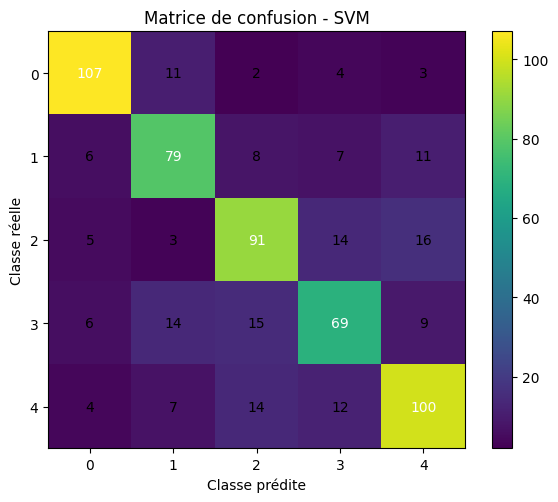

In [8]:
# %%
# Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
classes = np.unique(y)

plt.figure(figsize=(6, 5))
plt.imshow(cm, interpolation="nearest")
plt.title("Matrice de confusion - SVM")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
plt.xlabel("Classe prédite")
plt.ylabel("Classe réelle")

# Affichage des valeurs dans chaque cellule
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        val = cm[i, j]
        color = "white" if val > cm.max() / 2 else "black"
        plt.text(j, i, str(val), ha="center", va="center", color=color)

plt.tight_layout()
plt.show()

In [ ]:
# %%
# Sauvegarde du modèle SVM et du scaler pour une utilisation ultérieure
svm_model_path = os.path.join(MODEL_DIR, "svm_mfcc.joblib")
scaler_path = os.path.join(MODEL_DIR, "svm_scaler.joblib")

joblib.dump(svm_clf, svm_model_path)
joblib.dump(scaler, scaler_path)

print("✅ Modèle SVM sauvegardé dans :", svm_model_path)
print("✅ Scaler sauvegardé dans    :", scaler_path)